# Ensembling Feature Overview

This notebook provides an overview of the basic and advanced functionality of using ensemble methods in PySINDy. 

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

# define the Lorenz system
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

### Ensemble methods
One way to improve the robustness of a SINDy method is to use ensemble methods. Basically, we solve the regression problem many times on subsets (of size $n_{subset}$) of the time slices, generating $n_{models}$ models. All the coefficients are returned in model.coef_list and the average (bagging) can be used via np.mean(model.coef_list, axis=0) or the median (bragging) can be used via np.median(model.coef_list, axis=0). 

### The default number of models to generate is 20, and the default sampling strategy is to sample the entire time base with replacement, so that on average 60% or so of the data is seen. Default model is that the last fitted model is returned -- this is typically a bad approximation so use model.coef_list instead.

In [2]:
dt = .005
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
# add noise for more complexity
x_train = x_train + np.random.randn(x_train.shape[0], x_train.shape[1]) / 2.0

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True)
model.print()
ensemble_coefs = model.coef_list

x' = -10.183 x + 9.979 y
y' = 0.217 1 + 24.802 x + -0.928 x z
z' = 1.679 1 + -0.280 x + -2.584 z + 0.948 x y


### Library ensemble methods
Another way to do ensembling is to solve the regression problem on subsets of the candidate library, generating $p$ (the number of candidate terms) models. The syntax and code is a bit different, but the user-facing part is the same. Once again, the coefficients are returned in model.coef_list and the average can be used via np.mean(model.coef_list, axis=0). The default is still 20 generated models and the default sub-sampling is to chop one candidate term for each model.

In [3]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True)
model.print()
library_ensemble_coefs = model.coef_list

x' = -0.197 1 + -9.835 x + 9.817 y
y' = 0.727 1 + 25.960 x + -0.354 y + -0.954 x z
z' = 0.307 1 + -0.138 x + 0.106 y + -2.660 z + 0.998 x y


### Now do both types of ensembling with multiple candidate drops!

In [4]:
double_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=double_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, ensemble=True, n_candidates_to_drop=2)
model.print()
double_ensemble_coefs = model.coef_list

x' = -1.515 1 + -9.958 x + 9.887 y
y' = -4.805 1 + 27.576 x + -0.802 y + 0.172 z + -0.972 x z
z' = -0.877 1 + 4.105 x + -0.983 y + -2.655 z + 0.987 x y + -0.109 x z


### Alternatives to averaging (bagging) or taking the median (bragging) of the models: 
1. Weighted average of the coefficients, with weights corresponding to the mean-squared error with the testing (or training, if you like) $\dot{\mathbf{X}}$.
2. Define a function that does small integration forward of all the potential models for a bunch of a random initial conditions and chop any unstable models. Then repeat bagging or bragging.

In [5]:
from sklearn.metrics import mean_squared_error

def weighted_coefficient_average(coef_list, x_test, dt, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    coef_subtracted = np.zeros(np.shape(coef_list))
    for i in range(np.shape(coef_list)[0]):
        coef_subtracted[i, :, :] = np.asarray(coef_list)[i, :, :] - avg
    std = np.sqrt(np.average(coef_subtracted ** 2, axis=0, weights=mse))
    return avg, std

e_wavg, e_wstd = weighted_coefficient_average(ensemble_coefs, x_test, dt, ensemble_optimizer)
l_wavg, l_wstd = weighted_coefficient_average(library_ensemble_coefs, x_test, dt, library_ensemble_optimizer) 

def integration_metric(coef_list, optimizer):
    t_test = np.arange(0, 2, 0.01)    
    # Try 5 test trajectories
    for k in range(5):
        x0_test = (np.random.rand(3) - 0.5) * 10
        x_test = odeint(lorenz, x0_test, t_test)  
        for i in range(np.shape(coef_list)[0]):
            optimizer.coef_ = coef_list[i, :, :]
            x_test_sim = model.simulate(x0_test, t_test)
            if np.any(np.abs(x_test_sim) > 100):
                print('unstable model!')
                coef_list[i, :, :] = 0.0
    return coef_list

stable_ensemble_coefs = integration_metric(np.asarray(ensemble_coefs), ensemble_optimizer)
stable_library_ensemble_coefs = integration_metric(np.asarray(library_ensemble_coefs), library_ensemble_optimizer)

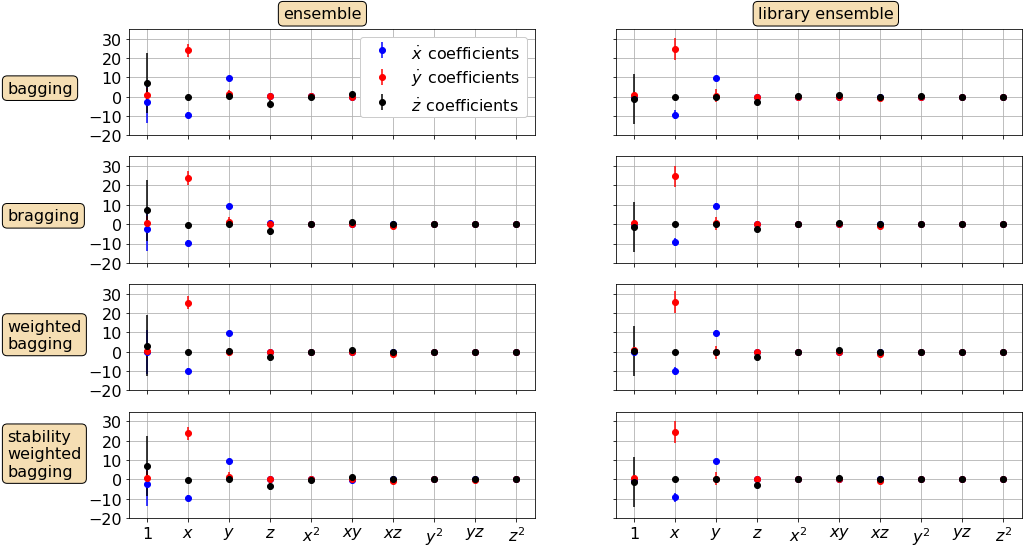

In [6]:
# Plot bagging results with error bars
coef_types = [np.mean(ensemble_coefs, axis=0), 
              np.mean(library_ensemble_coefs, axis=0), 
              e_wavg,
              l_wavg,
              np.median(ensemble_coefs, axis=0),
              np.median(library_ensemble_coefs, axis=0),
              np.mean(stable_ensemble_coefs, axis=0), 
              np.mean(stable_library_ensemble_coefs, axis=0), 
             ]
coef_stds = [np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             e_wstd,
             l_wstd,
             np.std(ensemble_coefs, axis=0), 
             np.std(library_ensemble_coefs, axis=0), 
             np.std(stable_ensemble_coefs, axis=0), 
             np.std(stable_library_ensemble_coefs, axis=0), 
             ]
colors = ['b', 'r', 'k']
props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
textstrs = ['bagging', 'bragging', 'weighted\nbagging', 'stability\nweighted\nbagging']
plt.figure(figsize=(16, 9))
for k, coefs in enumerate(coef_types):
    coef_std = coef_stds[k]
    plt.subplot(4, 2, k + 1)
    for i in range(coefs.shape[0]):
        plt.errorbar(range(coefs.shape[1]), coefs[i, :], yerr=coef_std[i, :], 
                     fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
    ax = plt.gca()
    ax.set_xticks(range(10))
    if k >= 6:
        xticknames = model.get_feature_names()
        for i in range(10):
            xticknames[i] = '$' + xticknames[i] + '$'
        ax.set_xticklabels(xticknames, verticalalignment='top')
    else:
        ax.set_xticklabels([])
    plt.ylim(-20, 35)
    if k == 0:
        plt.legend(fontsize=16, framealpha=1.0, loc='upper right')
        ax.text(0.38, 1.1, 'ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    if k == 1:
        ax.text(0.35, 1.1, 'library ensemble', transform=ax.transAxes, fontsize=16, bbox=props)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    ax.set_yticks([-20, -10, 0, 10, 20, 30])
    if k % 2 == 0:
        textstr = textstrs[k // 2]
        ax.text(-0.3, 0.4, textstr, transform=ax.transAxes, fontsize=16, bbox=props)
    else:
        ax.set_yticklabels([])
plt.savefig('ensemble_summary.pdf')

### Repeat ensembling but now make ~1000 models and plot the distributions of coefficients

In [60]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=1000)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

x' = 0.931 1 + -9.980 x + 10.390 y
y' = 4.584 1 + 24.183 x + 0.270 y + -0.924 x z
z' = 4.881 1 + -0.549 x + 0.851 y + -2.791 z + 1.019 x y


In [61]:
# Instantiate and fit the SINDy model
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=1000)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)

x' = -0.197 1 + -9.835 x + 9.817 y
y' = 1.172 1 + -6.895 x + 20.270 y + 0.263 z + -0.620 y^2
z' = 0.383 1 + -2.665 z + 0.997 x y


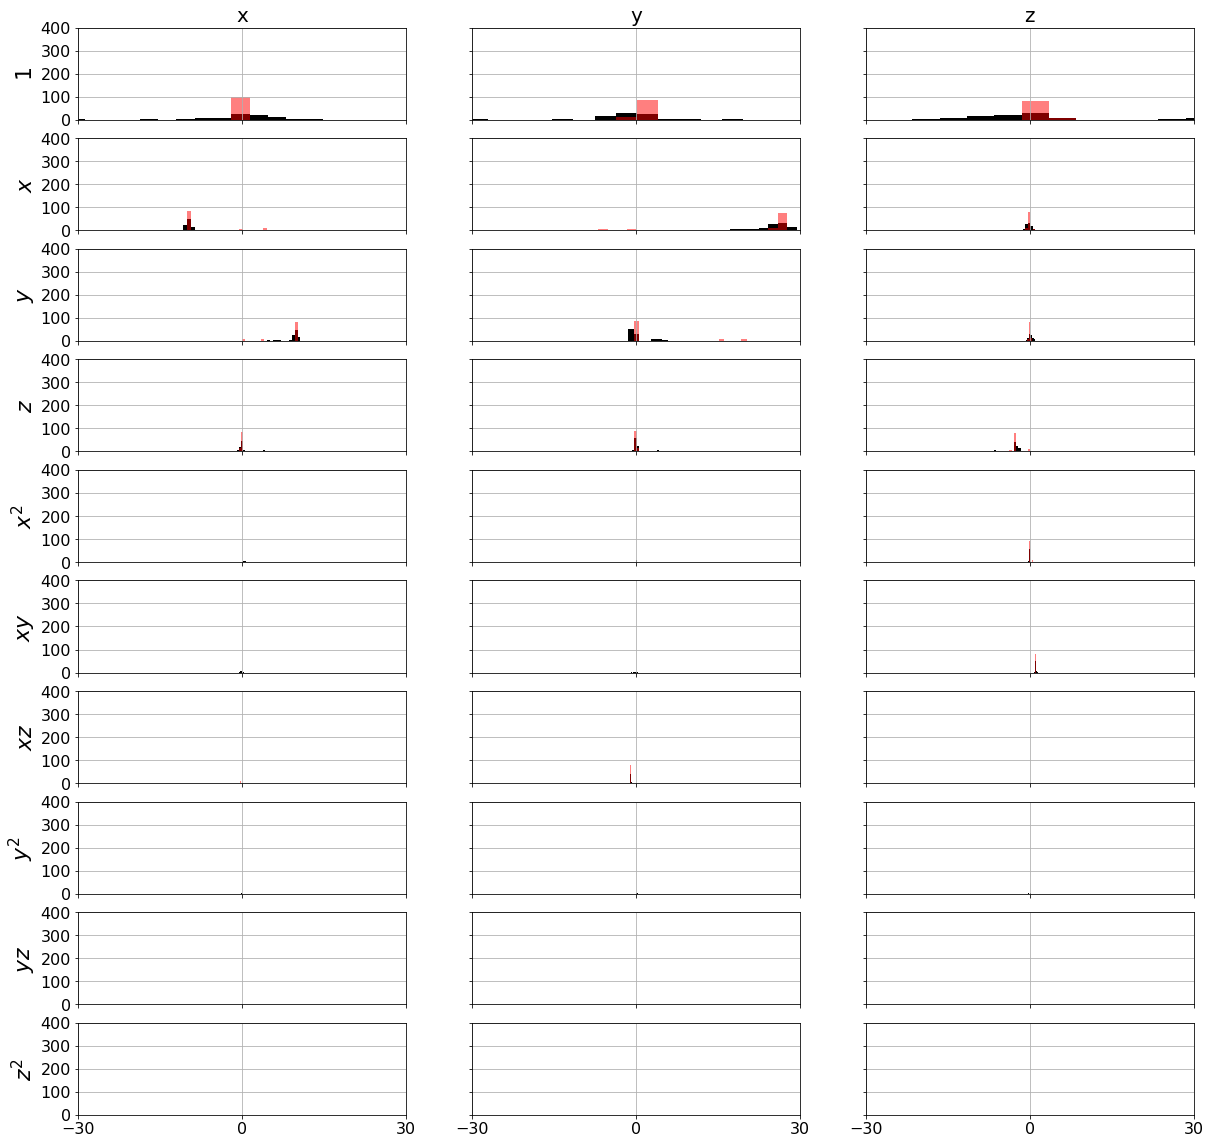

In [62]:
plt.figure(figsize=(20, 20))
min_overall = -30  # min(np.min(ensemble_coefs), np.min(library_ensemble_coefs))
max_overall = 30  # max(np.max(ensemble_coefs), np.max(library_ensemble_coefs))
for j in range(10):
    for i in range(3):

        plt.subplot(10, 3, i + 1 + j * 3)
        if j == 0:
            plt.title(feature_names[i], fontsize=20)
        min_bins = min(np.min(ensemble_coefs[:, i, j]), np.min(library_ensemble_coefs[:, i, j]))
        max_bins = max(np.max(ensemble_coefs[:, i, j]), np.max(library_ensemble_coefs[:, i, j]))
        bins = np.linspace(min_bins, max_bins, 22)
        plt.hist(ensemble_coefs[:, i, j], color='k', bins=bins) #, label=feature_names[j] + "' : " + xticknames[i])
        plt.hist(library_ensemble_coefs[:, i, j], bins=bins, color='r', alpha=0.5) #, label=feature_names[j] + "' : " + xticknames[i])
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel(xticknames[j], fontsize=22)
        else:
            ax.set_yticklabels([])
        if j != 9:
            ax.set_xticklabels([])
        ax.set_xticks([min_overall, 0, max_overall])
        plt.ylim(0, 400)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

In [79]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=100)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

x' = -0.362 1 + -9.862 x + 10.038 y + -0.158 x y + 0.104 y^2
y' = 0.774 1 + 27.739 x + -1.090 y + -0.176 z + 0.190 x^2 + -0.367 x y + -0.993 x z + 0.169 y^2
z' = -7.858 1 + -0.227 x + 0.155 y + -2.152 z + -0.137 x^2 + 1.068 x y


(100, 200, 3)


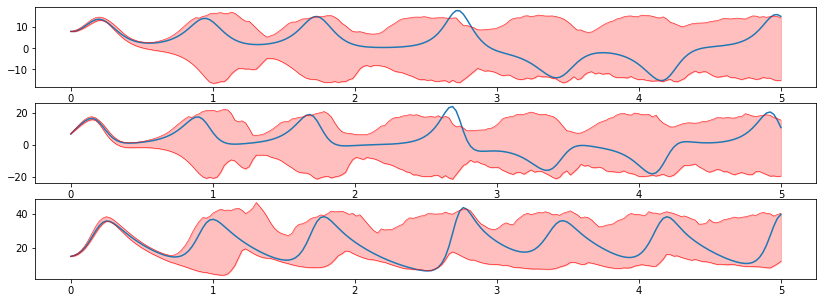

In [80]:
mean_ensemble_coefs = np.median(ensemble_coefs, axis=0)
t_test = np.linspace(0, 5, 200)
x_test_sim = model.simulate(x0_test, t_test)

x_test_sims = []
for i in range(ensemble_coefs.shape[0]):
    ensemble_optimizer.coef_ = ensemble_coefs[i, :, :]
    x_test_sims.append(model.simulate(x0_test, t_test))
print(np.shape(x_test_sims))

plt.figure(figsize=(14, 5))
bottom_line = np.percentile(x_test_sims, 2.5, axis=0)
top_line = np.percentile(x_test_sims, 97.5, axis=0)
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_test, x_test_sim[:, i])
    plt.plot(t_test, bottom_line[:, i], 'r', linewidth=0.5)
    plt.plot(t_test, top_line[:, i], 'r', linewidth=0.5)
    ax = plt.gca()
    ax.fill_between(t_test, bottom_line[:, i], top_line[:, i], color='r', alpha=0.25)

In [45]:
# Instantiate and fit the SINDy model
n_models = 20
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=n_models)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)
n_targets = len(feature_names)
n_features = len(model.get_feature_names())
print(n_targets, n_features)

# Calculate inclusion probabilities
inclusion_probabilities = np.count_nonzero(model.coef_list, axis=0) / n_models
print(inclusion_probabilities)

x' = -0.197 1 + -9.835 x + 9.817 y
y' = 0.727 1 + 25.960 x + -0.354 y + -0.954 x z
z' = 0.307 1 + -0.138 x + 0.106 y + -2.660 z + 0.998 x y
3 10
[[1.   0.95 0.85 0.2  0.2  0.2  0.2  0.2  0.2  0.  ]
 [1.   0.95 0.85 0.1  0.   0.   0.95 0.   0.1  0.  ]
 [1.   0.75 0.75 0.8  0.05 0.95 0.   0.05 0.   0.  ]]


# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

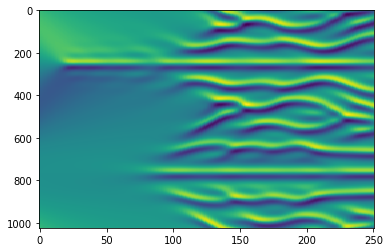

In [83]:
from scipy.io import loadmat 

data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')

In [85]:
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference

train = range(0, len(time) // 2, 1) # np.random.choice(len(time), int(len(time) * 0.8), replace=False)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                        temporal_grid=time, include_bias=True,
                        is_uniform=True, weak_form=True, num_pts_per_domain=50)

# Convert ut into a weak form using the pde_lib
def convert_ut(u, t, pde_lib):
    K = pde_lib.K
    domain_centers = pde_lib.domain_centers
    Hx = pde_lib.Hx
    Ht = pde_lib.Ht
    num_pts_per_domain = pde_lib.num_pts_per_domain
    num_time = len(t)
    ut_integral = np.zeros((K, 1))
    u_shaped = np.reshape(u, (len(x), len(t)))
    u_interp = RectBivariateSpline(x, t, u_shaped)
    for k in range(K):
        X = np.ravel(pde_lib.X[k, :, :])
        t = np.ravel(pde_lib.t[k, :, :])
        u_new = u_interp.ev(X, t)
        u_new = np.reshape(u_new, (num_pts_per_domain,
                                   num_pts_per_domain,
                                   1))
        w_diff = pde_lib._smooth_ppoly(
                    np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                    pde_lib.tgrid_k[k, :], k, 0, 0, 1
                )
        ut_integral[k] = (-1) * (
            trapezoid(
                trapezoid(
                    u_new * w_diff, x=pde_lib.xgrid_k[k, :], axis=0
                ),
                x=pde_lib.tgrid_k[k, :], axis=0
            )
        )
    return ut_integral
ut_train_integral = convert_ut(u_train, t_train, pde_lib)
ut_test_integral = convert_ut(u_test, t_test, pde_lib)
ut_integral = convert_ut(u, time, pde_lib)

In [95]:
optimizer = ps.SR3(threshold=0.1, max_iter=500, tol=1e-5, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()
weak_KS_models = model.coef_list
mean_weak_KS_models = np.mean(weak_KS_models, axis=0)
median_weak_KS_models = np.median(weak_KS_models, axis=0)
print(mean_weak_KS_models)
print(median_weak_KS_models)

# Calculate inclusion probabilities
inclusion_probabilities = np.count_nonzero(model.coef_list, axis=0) / n_models
print(inclusion_probabilities)

x0' = -1.004 x0_11 + -1.025 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


AttributeError: 'SINDy' object has no attribute 'coef_list'

In [93]:
def model_error(KS_pred_coef, KS_true_coef):
    return np.sqrt((KS_true_coef - KS_pred_coef) ** 2) / np.sqrt(KS_true_coef ** 2)

def success_rate(KS_pred_coef, KS_true_coef):
    return np.sqrt((KS_true_coef[np.nonzero(KS_true_coef)] - KS_pred_coef[np.nonzero(KS_true_coef)]) ** 2)

In [94]:
print(model.get_feature_names())
KS_true = np.zeros((1, 15))
KS_true[0, 3] = -1.0
KS_true[0, 5] = -1.0
KS_true[0, 6] = -1.0
model_error(mean_weak_KS_models, KS_true)
model_error(median_weak_KS_models, KS_true)

['1', 'x0', 'x0x0', 'x0_1', 'x0_11', 'x0_111', 'x0_1111', 'x0x0_1', 'x0x0x0_1', 'x0x0_11', 'x0x0x0_11', 'x0x0_111', 'x0x0x0_111', 'x0x0_1111', 'x0x0x0_1111']


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


array([[       inf,        inf,        inf, 0.85341881,        inf,
        5.90732146, 3.92018363,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf]])

In [ ]:
### Multiple noise instantiations (calculate success rate when train 100 models each on 
### 100 different trajectories -- 1 trajectory with 100 different noise added)

In [ ]:
### Calculate library ensemble + inclusion probabilities, then chop library terms below threshold
### Then rerun with smaller library with ensemble=True. 

### Inclusion probability different with the library_bagging. Multiply inclusion probability 
### by the percent of time the library term is there. 


### For distributions, can put a cross or mark where the true coefficient is


### Ensembling forecasting with the percentiles, can also plot the true dynamics with mean, median, percentiles. 